**Table of contents**<a id='toc0_'></a>    
- [CONFIG](#toc1_)    
- [Import libraries](#toc2_)    
- [Load data](#toc3_)    
- [Check class balancing](#toc4_)    
- [Image Data Generators](#toc5_)    
- [Simple](#toc6_)    
  - [Build & Compile](#toc6_1_)    
  - [Train](#toc6_2_)    
  - [Test](#toc6_3_)    
  - [Confusion Matrix](#toc6_4_)    
- [ResNet-18](#toc7_)    
  - [Build & Compile](#toc7_1_)    
  - [Train](#toc7_2_)    
  - [Test](#toc7_3_)    
  - [Confusion Matrix](#toc7_4_)    
- [Graphs](#toc8_)    
  - [Epochs vs Loss](#toc8_1_)    
  - [Epochs vs Accuracy](#toc8_2_)    
    - [Accuracy](#toc8_2_1_)    
    - [Total](#toc8_2_2_)    
    - [By Class](#toc8_2_3_)    
      - [Simple](#toc8_2_3_1_)    
        - [Class wise accuracy](#toc8_2_3_1_1_)    
        - [Top 10 most and least accurate classes](#toc8_2_3_1_2_)    
      - [ResNet](#toc8_2_3_2_)    
        - [Class wise accuracy](#toc8_2_3_2_1_)    
        - [Top 10 most and least accurate classes](#toc8_2_3_2_2_)    
- [Predictions](#toc9_)    
  - [Simple](#toc9_1_)    
  - [ResNet](#toc9_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[CONFIG](#toc0_)


In [33]:
DATA_PATH = "Sketch_EITZ"
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 64
NUM_CLASSES = 250
EPOCHS = 50

# <a id='toc2_'></a>[Import libraries](#toc0_)


In [34]:
import os
import pandas as pd

import tensorflow as tf
import numpy as np
import models.simple as simple
import models.resnet as resnet
import metrics as metrics
import matplotlib.pyplot as plt

# <a id='toc3_'></a>[Load data](#toc0_)


In [35]:
file_path = os.path.join(DATA_PATH, "train.txt")
test_path = os.path.join(DATA_PATH, "test.txt")
mapping_path = os.path.join(DATA_PATH, "mapping.txt")

df = pd.read_csv(file_path, names=["images", "labels"], sep="\t")
df_test = pd.read_csv(test_path, names=["images", "labels"], sep="\t")

classes = pd.read_csv(mapping_path, names=["class", "idx"], sep="\t").to_dict(
    orient="dict"
)["class"]

df["labels"] = df["labels"].map(classes)
df["images"] = df["images"].map(lambda x: os.path.join(DATA_PATH, x))

df_test["labels"] = df_test["labels"].map(classes)
df_test["images"] = df_test["images"].map(lambda x: os.path.join(DATA_PATH, x))

# <a id='toc4_'></a>[Check class balancing](#toc0_)

Podemos ver que la diferencia entre la con más y menos imagenes no es muy grande, por lo que no es necesario hacer un balanceo de clases.


labels
bell             74
lighter          72
socks            71
blimp            71
standing_bird    71
                 ..
submarine        56
palm_tree        56
octopus          55
brain            55
grapes           54
Name: count, Length: 250, dtype: int64


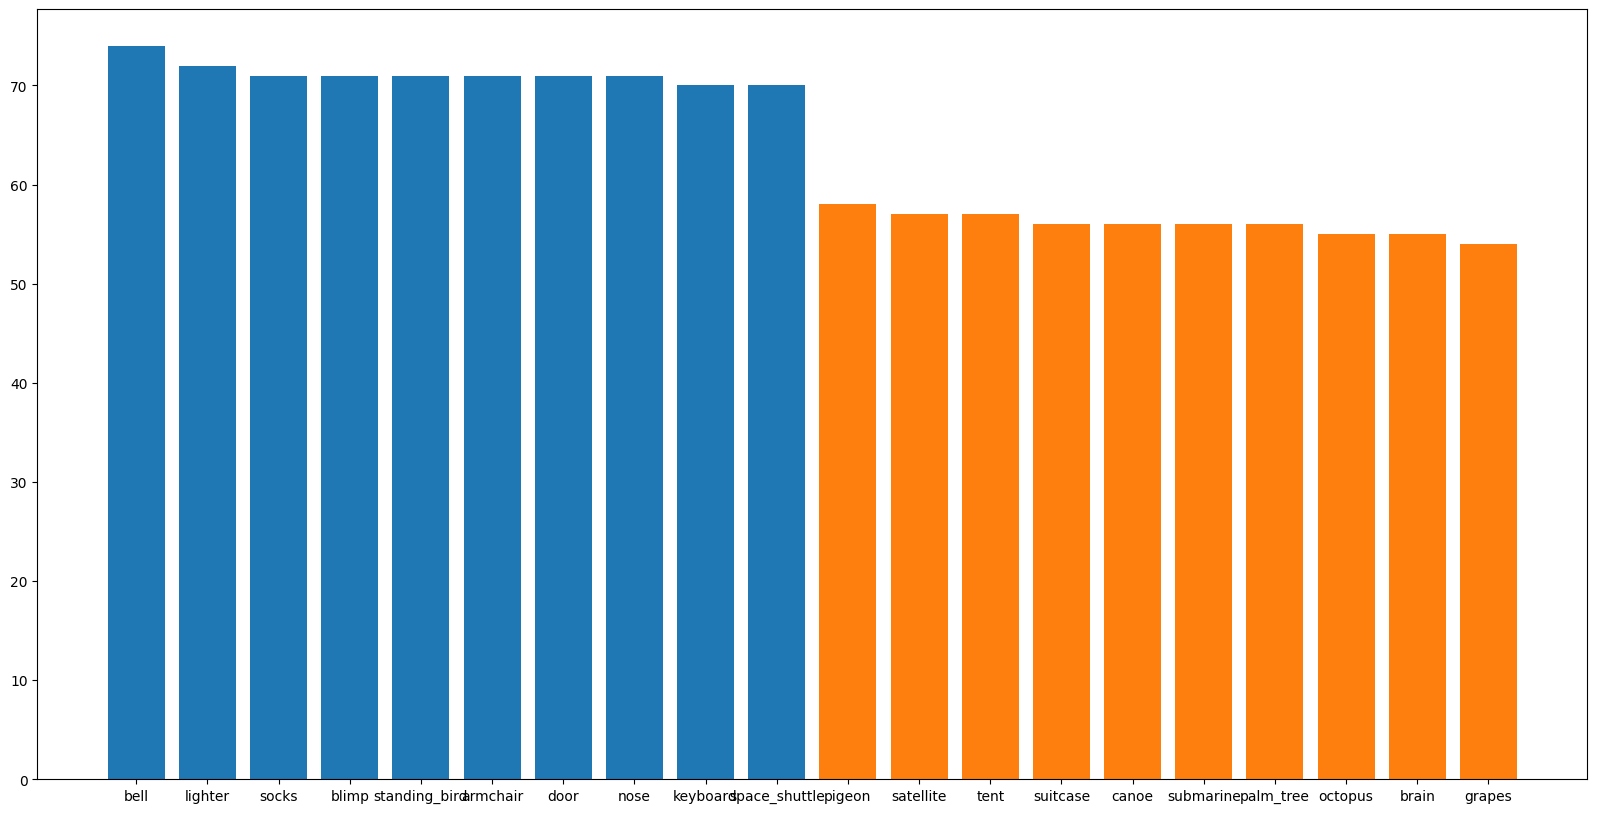

In [36]:
class_counts = df["labels"].value_counts()
print(class_counts)
plt.figure(figsize=(20, 10))
plt.bar(class_counts.index[:10], class_counts.values[:10])
plt.bar(class_counts.index[-10:], class_counts.values[-10:])
plt.show()


# <a id='toc5_'></a>[Image Data Generators](#toc0_)


In [37]:
datagen_kwargs = dict(rescale=1.0 / 255, validation_split=0.20)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

train_generator = train_datagen.flow_from_dataframe(
    df,
    x_col="images",
    y_col="labels",
    target_size=IMAGE_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=None,
    subset="training",
    classes=list(classes.values()),  # explicitly specify the order of classes
)

validation_generator = train_datagen.flow_from_dataframe(
    df,
    x_col="images",
    y_col="labels",
    target_size=IMAGE_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=None,
    subset="validation",
    classes=list(classes.values()),  # explicitly specify the order of classes
)

Found 12800 validated image filenames belonging to 250 classes.
Found 3200 validated image filenames belonging to 250 classes.


# <a id='toc6_'></a>[Simple](#toc0_)


## <a id='toc6_1_'></a>[Build & Compile](#toc0_)


In [38]:
if os.path.exists("models/simple.keras"):
    loaded = True
    model_simple = tf.keras.models.load_model("models/simple.keras")
else:
    loaded = False
    model_simple = simple.SimpleModel(NUM_CLASSES)

    shape_data = train_generator[0][0].shape[1:]
    model_simple = model_simple.model(shape_data)

    model_simple.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.CategoricalAccuracy()],
    )
    model_simple.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 128, 128, 32)         320       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_3 (Bat  (None, 128, 128, 32)         128       ['conv1[0][0]']               
 chNormalization)                                                                                 
                                                                                                  
 re_lu_1 (ReLU)              multiple                     0         ['batch_normalization_3[

## <a id='toc6_2_'></a>[Train](#toc0_)


In [39]:
if not loaded:
    history_simple = model_simple.fit(
        train_generator, epochs=EPOCHS, validation_data=validation_generator
    )
    model_simple.save("models/simple.keras")


Epoch 1/50


/Users/smaluk/.local/share/virtualenvs/RVDL-i8K3yOnr/lib/python3.11/site-packages/keras/src/backend.py:5562: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-08-30 17:34:33.016598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - ETA: 0s - loss: 3.9837 - categorical_accuracy: 0.2148

2023-08-30 17:34:57.573726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 29s 122ms/step - loss: 3.9837 - categorical_accuracy: 0.2148 - val_loss: 5.0133 - val_categorical_accuracy: 0.0616
Epoch 2/50
200/200 [==============================] - 23s 113ms/step - loss: 2.3198 - categorical_accuracy: 0.5122 - val_loss: 3.1415 - val_categorical_accuracy: 0.3191
Epoch 3/50
200/200 [==============================] - 23s 113ms/step - loss: 1.2671 - categorical_accuracy: 0.7495 - val_loss: 3.3494 - val_categorical_accuracy: 0.2788
Epoch 4/50
200/200 [==============================] - 23s 113ms/step - loss: 0.3584 - categorical_accuracy: 0.9595 - val_loss: 3.6094 - val_categorical_accuracy: 0.2694
Epoch 5/50
200/200 [==============================] - 23s 113ms/step - loss: 0.0563 - categorical_accuracy: 0.9991 - val_loss: 2.7565 - val_categorical_accuracy: 0.3975
Epoch 6/50
200/200 [==============================] - 23s 112ms/step - loss: 0.0144 - categorical_accuracy: 1.0000 - val_loss: 2.4863 - val_categorical_accuracy: 0.46

## <a id='toc6_3_'></a>[Test](#toc0_)


In [40]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

test_generator = train_datagen.flow_from_dataframe(
    df_test,
    x_col="images",
    y_col="labels",
    target_size=IMAGE_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=None,
    subset="training",
    classes=list(classes.values()),  # explicitly specify the order of classes
)

Found 3200 validated image filenames belonging to 250 classes.


## <a id='toc6_4_'></a>[Confusion Matrix](#toc0_)


In [41]:
# prediction using directly the trained model
# there is also a function called -- predict -- , you can check it
mc_simple = 0
for batch in range(len(test_generator)):
    imgs = test_generator[batch][0]

    y_true = test_generator[batch][1]
    y_pred = model_simple(imgs, training=False)

    # computing confusion_matrix
    mc_simple += metrics.confusion_matrix(y_true, y_pred, NUM_CLASSES)

print(mc_simple)
# mc as percentages
rmc = mc_simple.astype(np.float32) / np.sum(mc_simple, axis=1, keepdims=True)
rmc = (rmc * 100).astype(np.int32) / 100

print(rmc)


[[ 3  0  0 ...  0  0  0]
 [ 0  7  0 ...  0  0  0]
 [ 0  0  3 ...  0  0  0]
 ...
 [ 0  0  0 ... 11  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  5]]
[[0.27 0.   0.   ... 0.   0.   0.  ]
 [0.   0.63 0.   ... 0.   0.   0.  ]
 [0.   0.   0.5  ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.52 0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.29]]


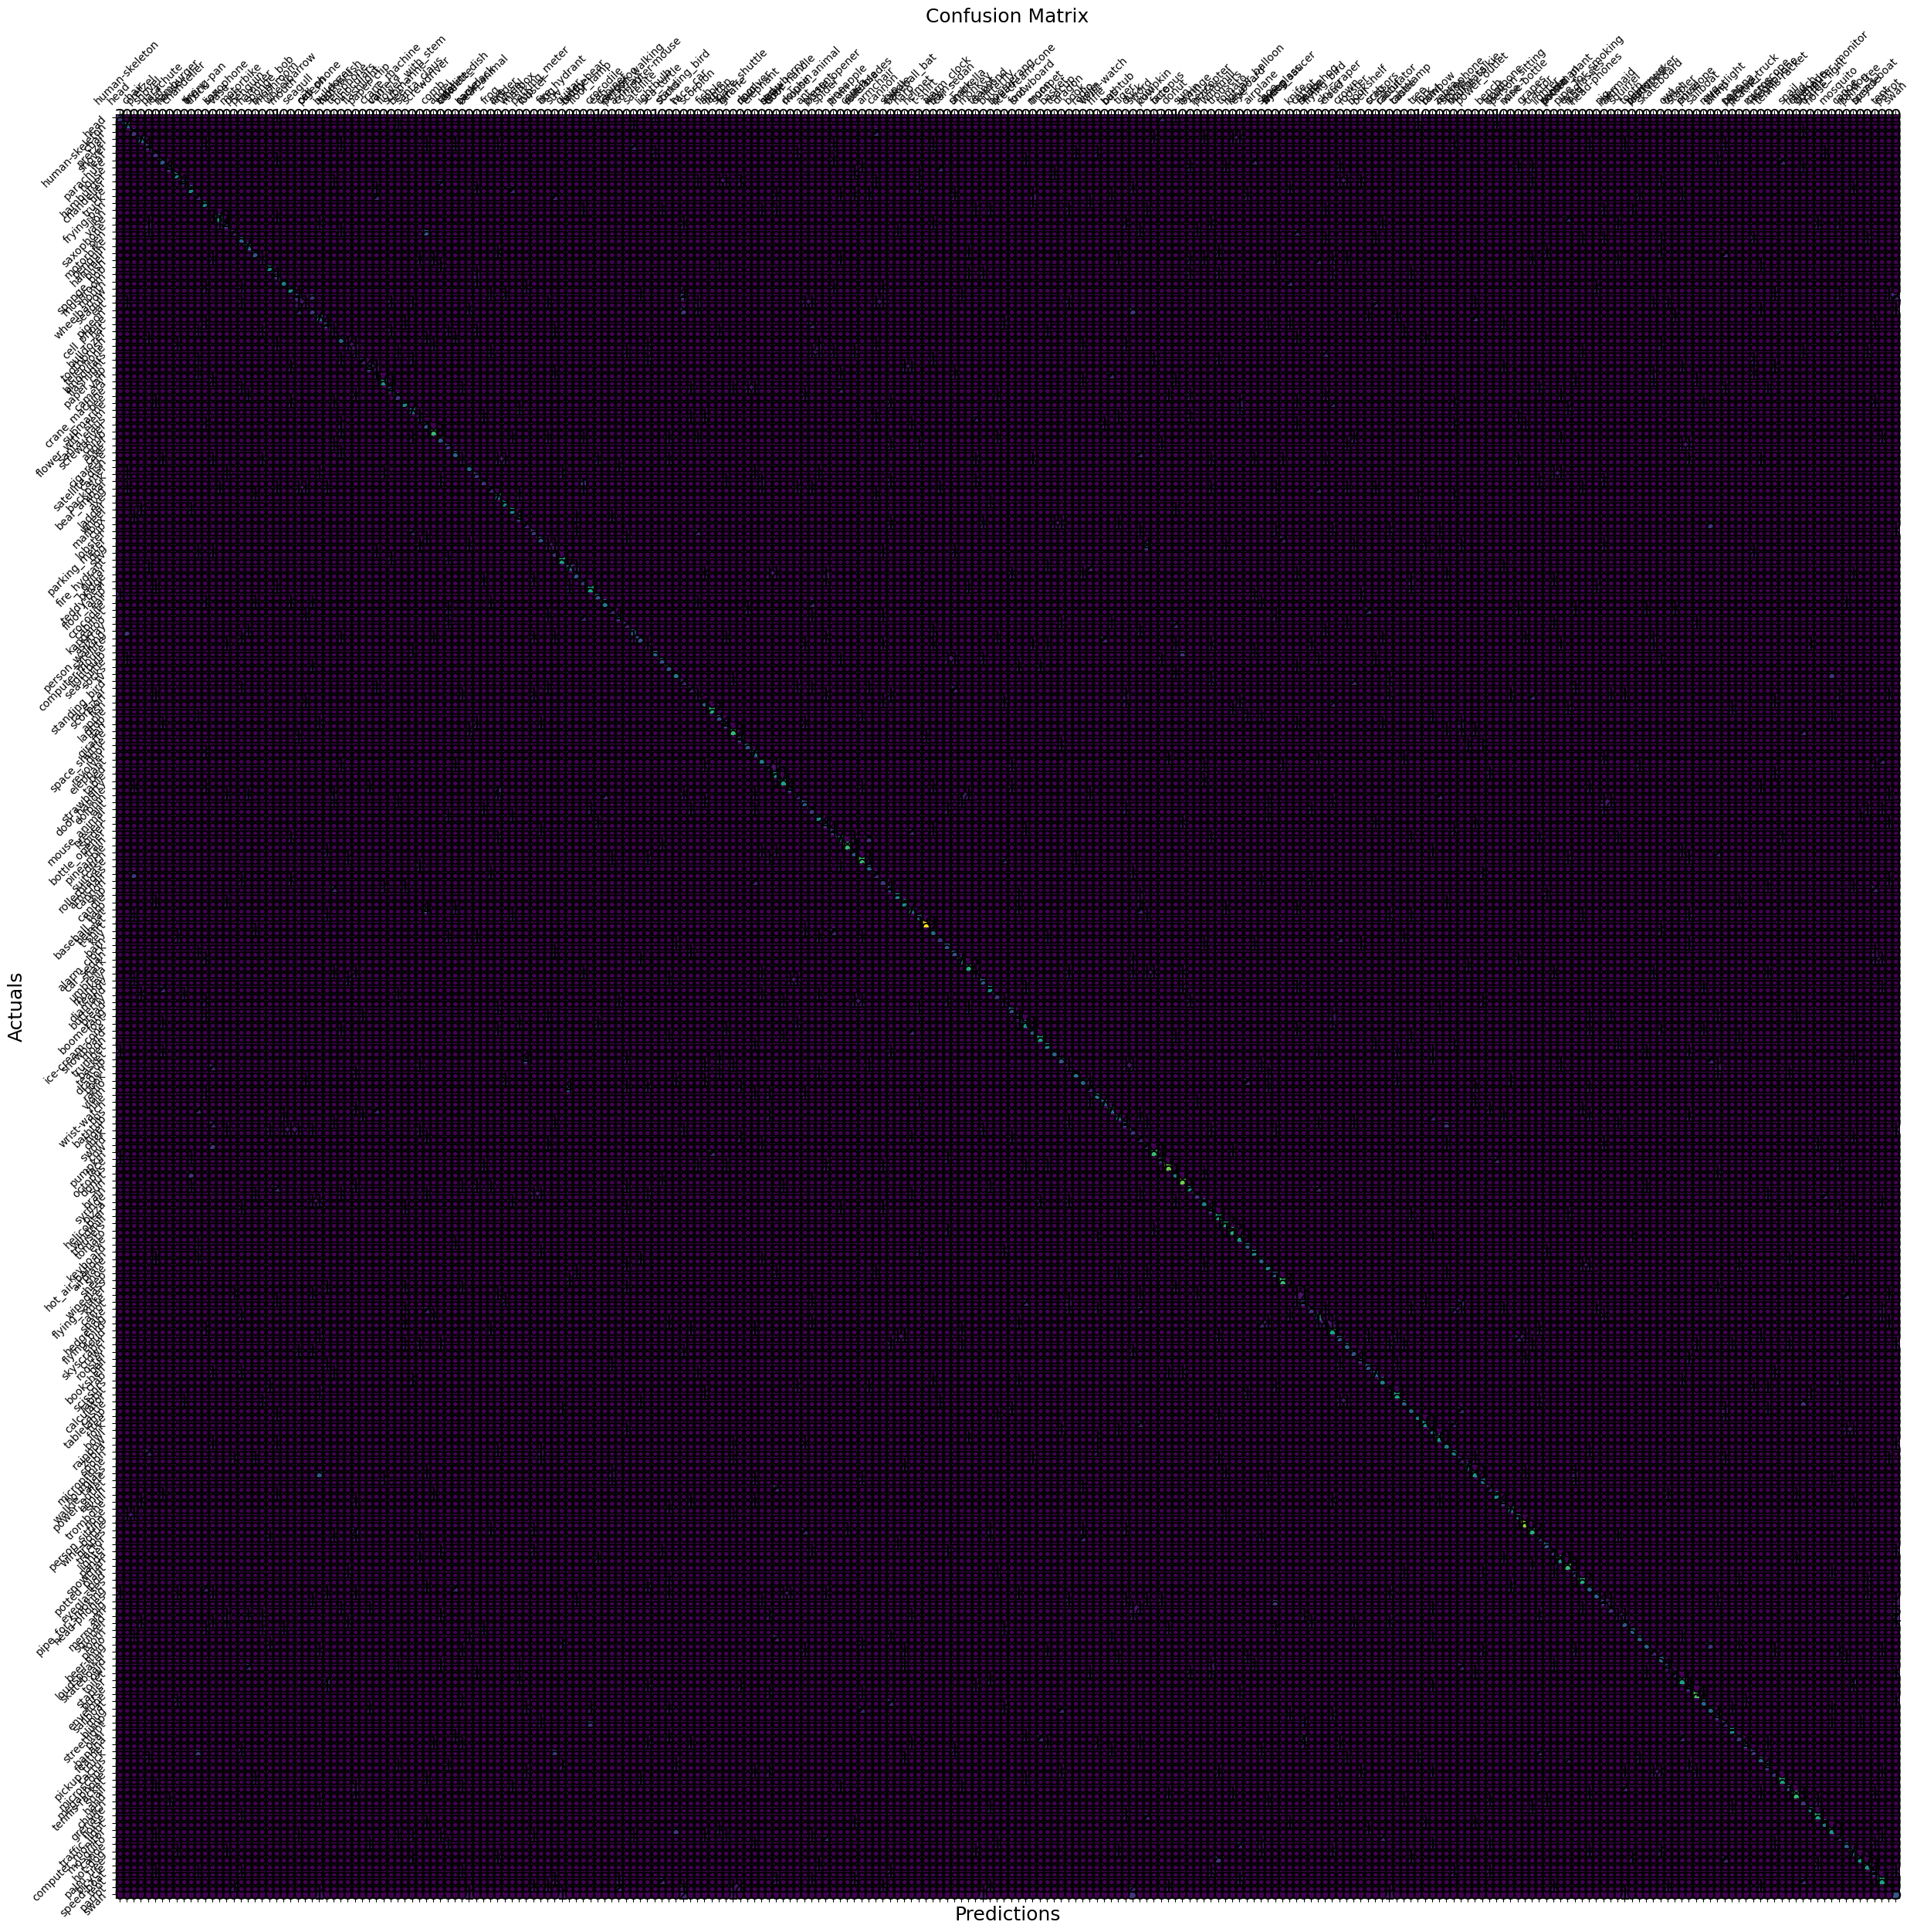

In [42]:
fig, ax = plt.subplots(figsize=(30, 30))

ax.matshow(mc_simple)
for i in range(mc_simple.shape[0]):
    for j in range(mc_simple.shape[1]):
        ax.text(
            x=j,
            y=i,
            s=round(mc_simple[i, j], 2),
            va="center",
            ha="center",
            size="xx-large",
        )
plt.xlabel("Predictions", fontsize=18)
plt.ylabel("Actuals", fontsize=18)
plt.title("Confusion Matrix", fontsize=18)
plt.xticks(range(NUM_CLASSES), labels=classes.values(), rotation=45)
plt.yticks(range(NUM_CLASSES), labels=classes.values(), rotation=45)
plt.show()


# <a id='toc7_'></a>[ResNet-18](#toc0_)


## <a id='toc7_1_'></a>[Build & Compile](#toc0_)


In [43]:
if os.path.exists("models/resnet.keras"):
    loaded = True
    model_resnet = tf.keras.models.load_model("models/resnet.keras")
else:
    loaded = False
    block_sizes = [2, 2, 2, 2]
    filters = [64, 128, 256, 512]
    model_resnet = resnet.ResNet(block_sizes, filters, NUM_CLASSES)
    input_shape = (BATCH_SIZE, 128, 128, 1)
    model_resnet.build(input_shape=input_shape)
    model_resnet.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.CategoricalAccuracy()],
    )
model_resnet.summary()


Model: "res_net_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 backbone (ResNetBackbone)   multiple                  11176256  
                                                                 
 global_average_pooling2d_1  multiple                  0         
  (GlobalAveragePooling2D)                                       
                                                                 
 classifier (Dense)          multiple                  128250    
                                                                 
Total params: 11304506 (43.12 MB)
Trainable params: 11296698 (43.09 MB)
Non-trainable params: 7808 (30.50 KB)
_________________________________________________________________


## <a id='toc7_2_'></a>[Train](#toc0_)


In [44]:
if not loaded:
    history = model_resnet.fit(
        train_generator, epochs=EPOCHS, validation_data=validation_generator
    )
    model_resnet.save("models/resnet.keras")


Epoch 1/50


2023-08-30 17:54:19.296459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - ETA: 0s - loss: 4.6074 - categorical_accuracy: 0.0705

2023-08-30 17:54:52.043650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


200/200 [==============================] - 38s 152ms/step - loss: 4.6074 - categorical_accuracy: 0.0705 - val_loss: 41.5339 - val_categorical_accuracy: 0.0037
Epoch 2/50
200/200 [==============================] - 28s 141ms/step - loss: 3.5117 - categorical_accuracy: 0.2009 - val_loss: 4.8995 - val_categorical_accuracy: 0.1013
Epoch 3/50
200/200 [==============================] - 28s 140ms/step - loss: 2.8306 - categorical_accuracy: 0.3231 - val_loss: 10.0376 - val_categorical_accuracy: 0.0225
Epoch 4/50
200/200 [==============================] - 28s 141ms/step - loss: 2.2954 - categorical_accuracy: 0.4320 - val_loss: 7.2497 - val_categorical_accuracy: 0.0634
Epoch 5/50
200/200 [==============================] - 28s 141ms/step - loss: 1.8820 - categorical_accuracy: 0.5183 - val_loss: 6.7469 - val_categorical_accuracy: 0.0950
Epoch 6/50
200/200 [==============================] - 28s 140ms/step - loss: 1.5307 - categorical_accuracy: 0.5929 - val_loss: 4.8851 - val_categorical_accuracy: 0.

## <a id='toc7_3_'></a>[Test](#toc0_)


In [45]:
datagen_kwargs = dict(rescale=1.0 / 255, validation_split=0)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

test_generator = train_datagen.flow_from_dataframe(
    df_test,
    x_col="images",
    y_col="labels",
    target_size=IMAGE_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=None,
    subset="training",
    classes=list(classes.values()),  # explicitly specify the order of classes
)

Found 3200 validated image filenames belonging to 250 classes.


## <a id='toc7_4_'></a>[Confusion Matrix](#toc0_)


In [46]:
# prediction using directly the trained model
# there is also a function called -- predict -- , you can check it
mc_resnet = 0
for batch in range(len(test_generator)):
    imgs = test_generator[batch][0]

    y_true = test_generator[batch][1]
    y_pred = model_resnet(imgs, training=False)

    # computing confusion_matrix
    mc_resnet += metrics.confusion_matrix(y_true, y_pred, NUM_CLASSES)
# model_file = 'simple_model'
# model_file = 'resnet_model'
# model.save(model_file)
# print('model was saved at {}'.format(model_file))
# print mc
print(mc_resnet)
# mc as percentages
rmc = mc_resnet.astype(np.float32) / np.sum(mc_resnet, axis=1, keepdims=True)
rmc = (rmc * 100).astype(np.int32) / 100

print(rmc)

[[ 4  0  0 ...  0  0  0]
 [ 0  7  0 ...  0  0  0]
 [ 0  0  4 ...  0  0  0]
 ...
 [ 0  0  0 ... 13  0  0]
 [ 0  0  0 ...  0  4  1]
 [ 0  0  0 ...  0  0  4]]
[[0.36 0.   0.   ... 0.   0.   0.  ]
 [0.   0.63 0.   ... 0.   0.   0.  ]
 [0.   0.   0.66 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.61 0.   0.  ]
 [0.   0.   0.   ... 0.   0.25 0.06]
 [0.   0.   0.   ... 0.   0.   0.23]]


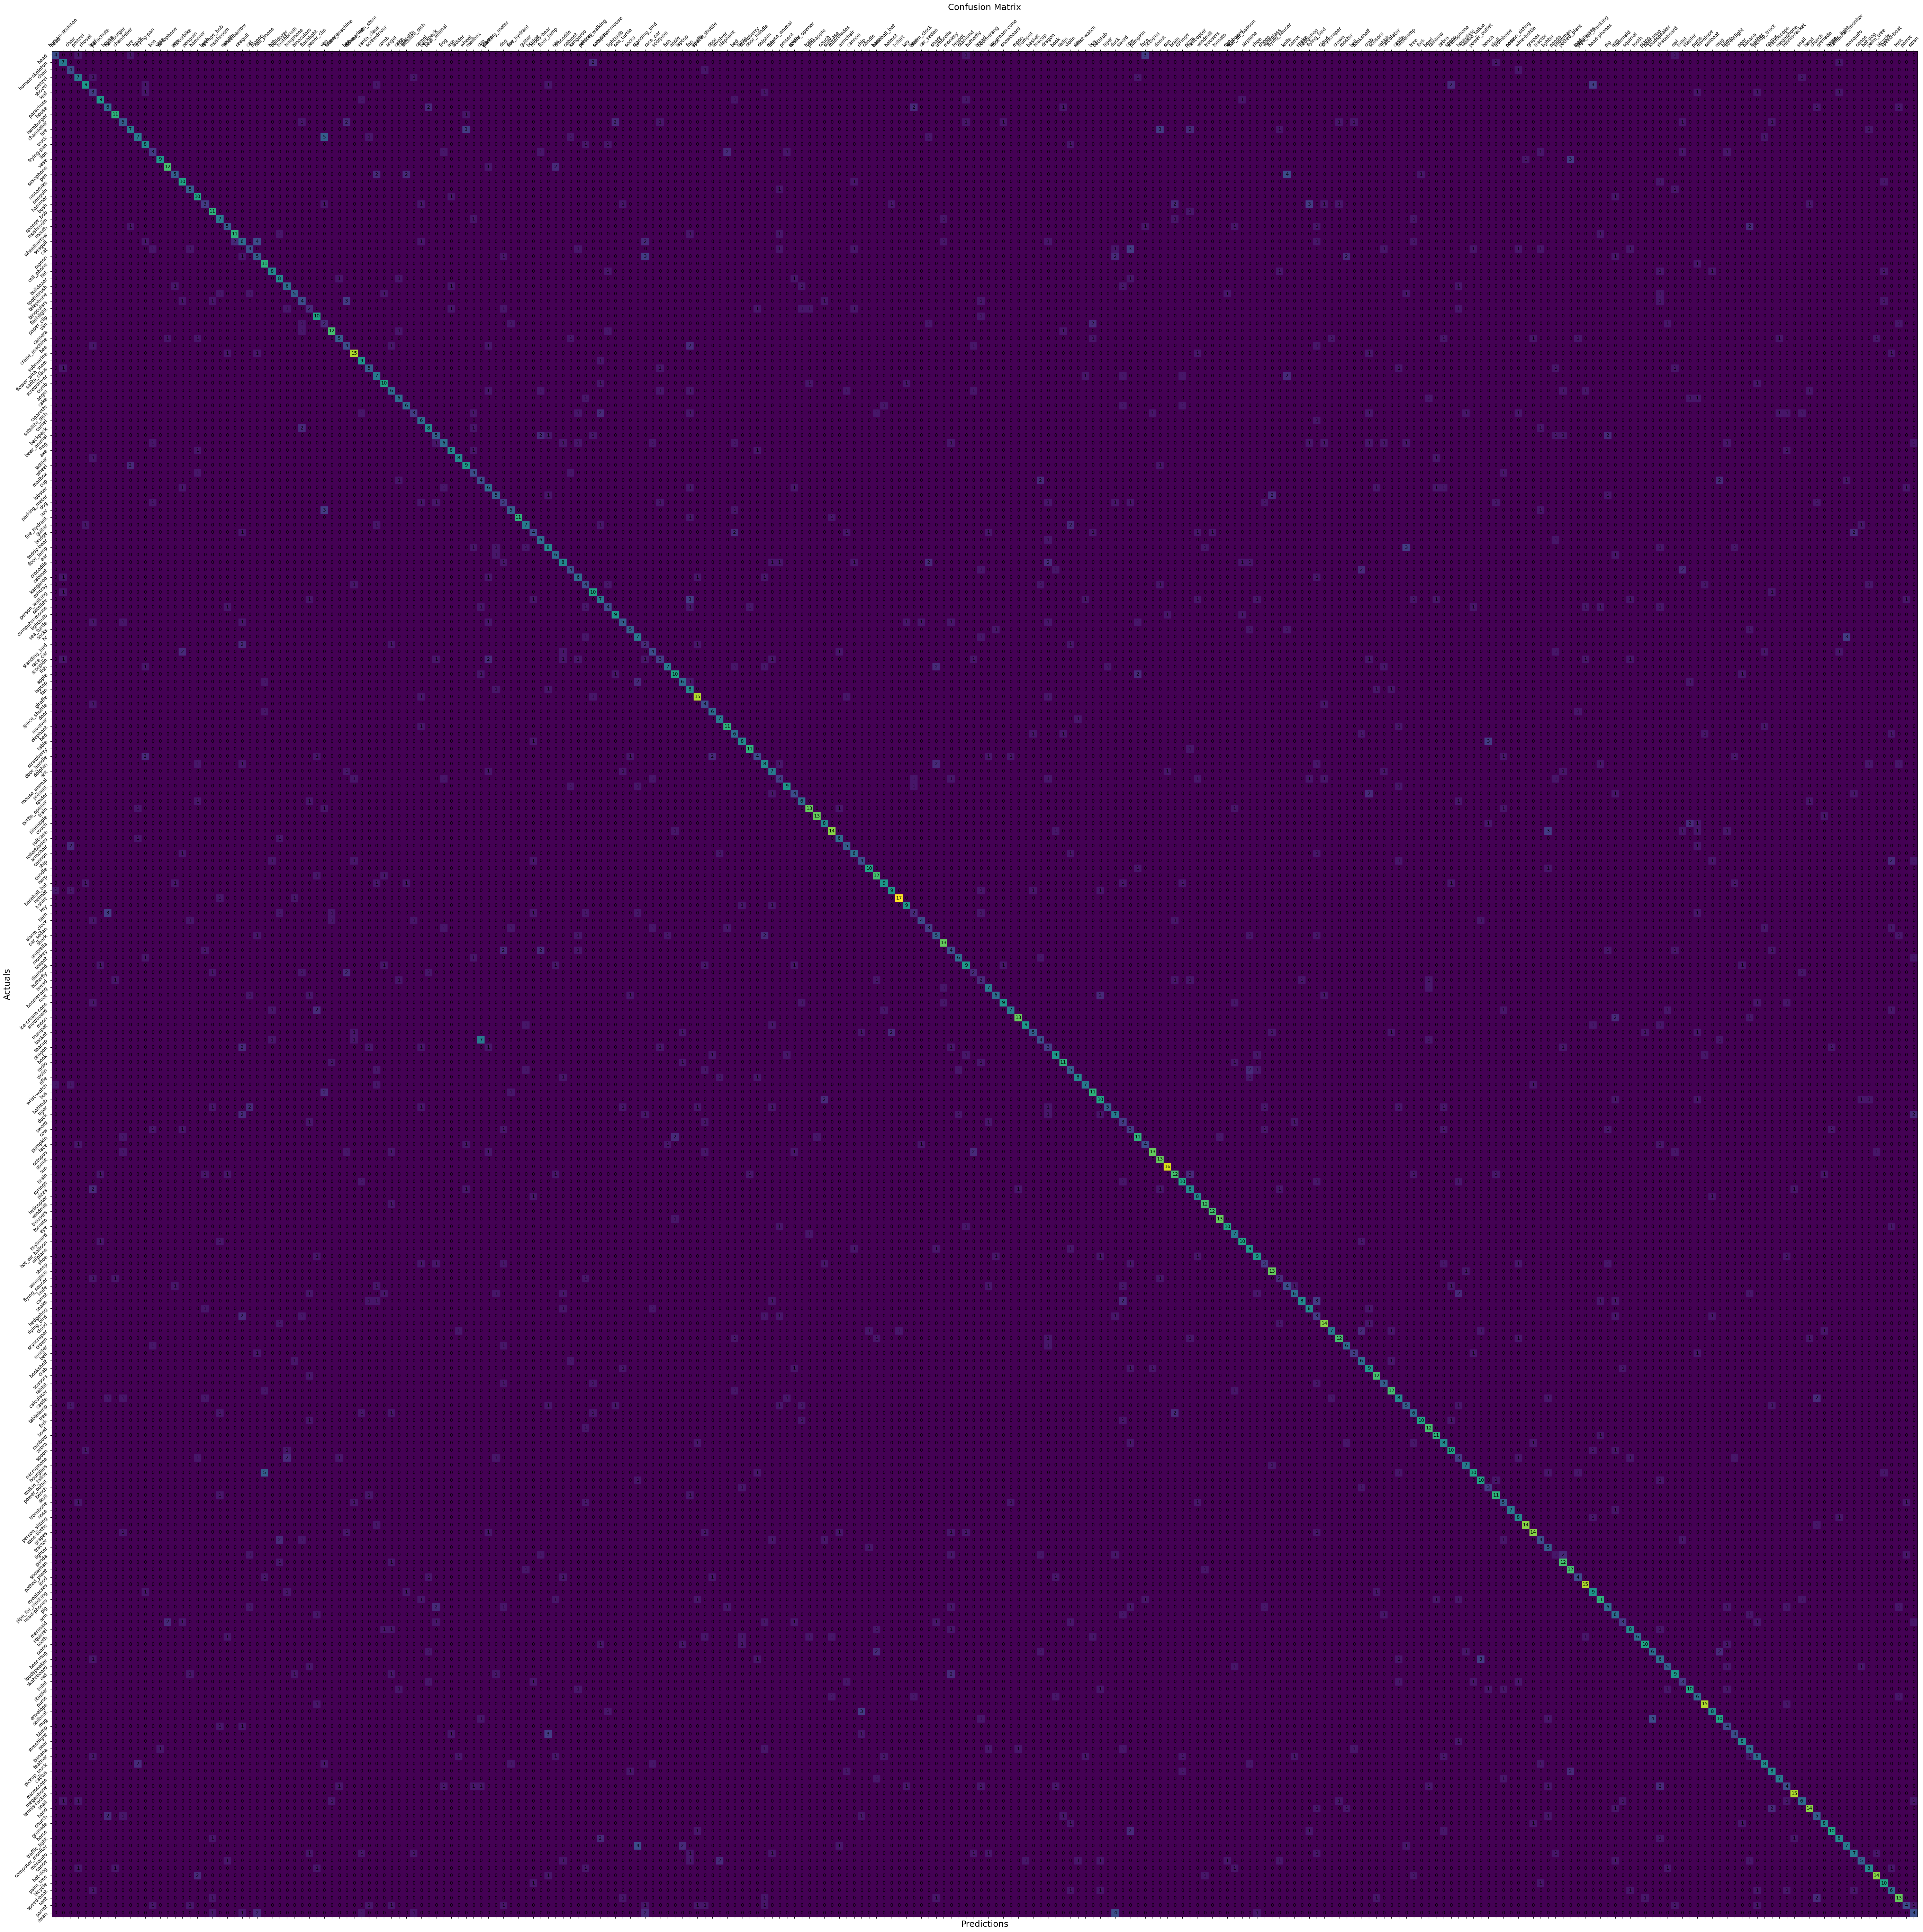

In [47]:
fig, ax = plt.subplots(figsize=(70, 70))
ax.matshow(mc_resnet)
for i in range(mc_resnet.shape[0]):
    for j in range(mc_resnet.shape[1]):
        ax.text(x=j, y=i, s=round(mc_resnet[i, j], 2), va="center", ha="center")
plt.xlabel("Predictions", fontsize=18)
plt.ylabel("Actuals", fontsize=18)
plt.title("Confusion Matrix", fontsize=18)
plt.xticks(range(NUM_CLASSES), labels=classes.values(), rotation=45)
plt.yticks(range(NUM_CLASSES), labels=classes.values(), rotation=45)
plt.show()

# <a id='toc8_'></a>[Graphs](#toc0_)


In [48]:
acc_simple = history_simple.history["categorical_accuracy"]
val_acc_simple = history_simple.history["val_categorical_accuracy"]
loss_simple = history_simple.history["loss"]
val_loss_simple = history_simple.history["val_loss"]
acc_resnet = history.history["categorical_accuracy"]
val_acc_resnet = history.history["val_categorical_accuracy"]
loss_resnet = history.history["loss"]
val_loss_resnet = history.history["val_loss"]
epochs = range(1, EPOCHS + 1)

## <a id='toc8_1_'></a>[Epochs vs Loss](#toc0_)


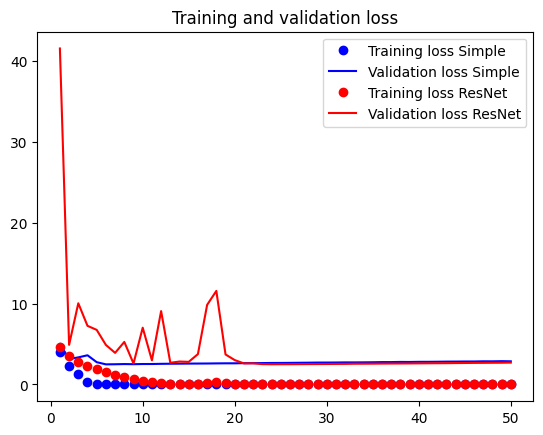

In [49]:
plt.plot(epochs, loss_simple, "bo", label="Training loss Simple")
plt.plot(epochs, val_loss_simple, "b", label="Validation loss Simple")
plt.plot(epochs, loss_resnet, "ro", label="Training loss ResNet")
plt.plot(epochs, val_loss_resnet, "r", label="Validation loss ResNet")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## <a id='toc8_2_'></a>[Epochs vs Accuracy](#toc0_)


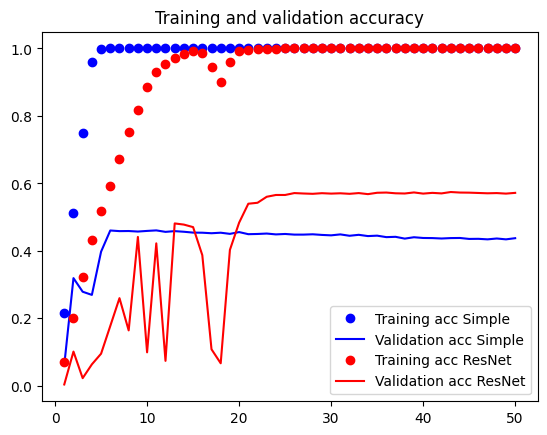

In [50]:
plt.plot(epochs, acc_simple, "bo", label="Training acc Simple")
plt.plot(epochs, val_acc_simple, "b", label="Validation acc Simple")
plt.plot(epochs, acc_resnet, "ro", label="Training acc ResNet")
plt.plot(epochs, val_acc_resnet, "r", label="Validation acc ResNet")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

### <a id='toc8_2_1_'></a>[Accuracy](#toc0_)


### <a id='toc8_2_2_'></a>[Total](#toc0_)


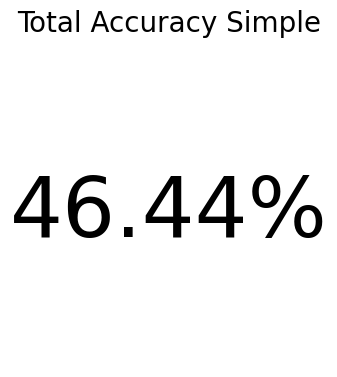

In [51]:
# Calculate total accuracy from confusion matrix
total_correct = np.trace(mc_simple)
total_samples = np.sum(mc_simple)
total_accuracy = total_correct / total_samples * 100

# Plotting
plt.figure(figsize=(4, 4))
plt.text(0.5, 0.5, f"{total_accuracy:.2f}%", ha="center", va="center", fontsize=60)
plt.axis("off")
plt.title("Total Accuracy Simple", pad=20, fontsize=20)
plt.show()

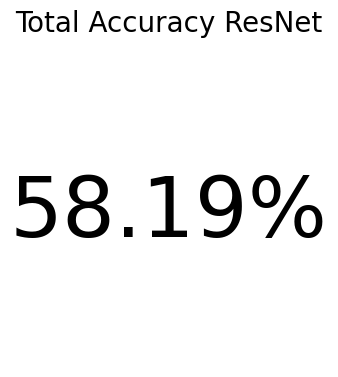

In [52]:
# Calculate total accuracy from confusion matrix
total_correct = np.trace(mc_resnet)
total_samples = np.sum(mc_resnet)
total_accuracy = total_correct / total_samples * 100

# Plotting
plt.figure(figsize=(4, 4))
plt.text(0.5, 0.5, f"{total_accuracy:.2f}%", ha="center", va="center", fontsize=60)
plt.axis("off")
plt.title("Total Accuracy ResNet", pad=20, fontsize=20)
plt.show()

### <a id='toc8_2_3_'></a>[By Class](#toc0_)


#### <a id='toc8_2_3_1_'></a>[Simple](#toc0_)


##### <a id='toc8_2_3_1_1_'></a>[Class wise accuracy](#toc0_)


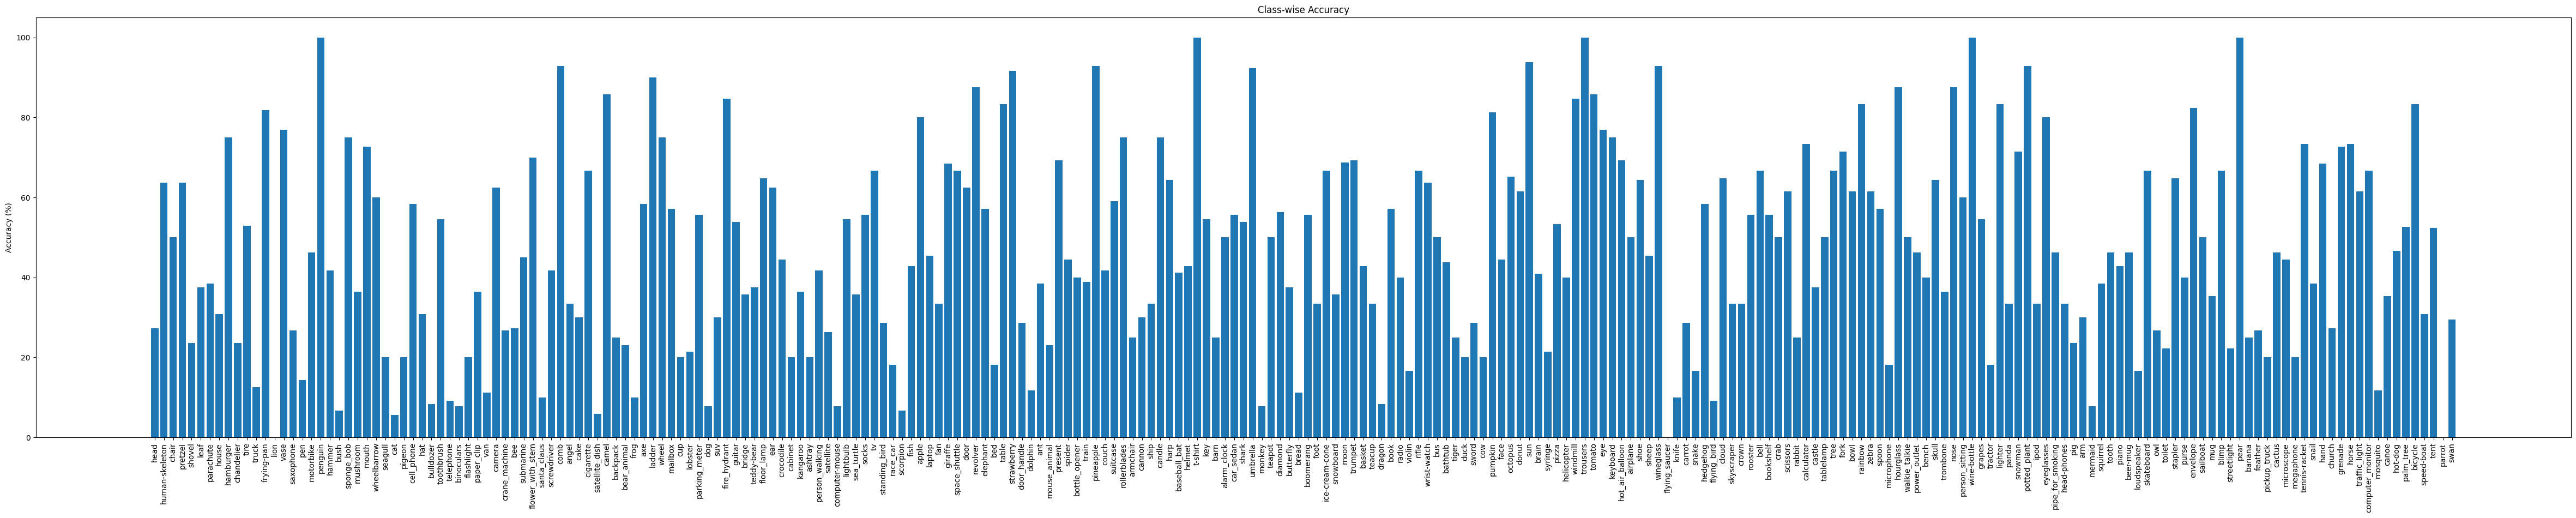

In [53]:
# Calculate class-wise accuracy
class_wise_accuracy = np.diag(mc_simple) / np.sum(mc_simple, axis=1) * 100

# Plotting
plt.figure(figsize=(60, 10))
plt.bar(range(NUM_CLASSES), class_wise_accuracy)
plt.xticks(range(NUM_CLASSES), labels=classes.values(), rotation=90)
plt.ylabel("Accuracy (%)")
plt.title("Class-wise Accuracy")
plt.show()

##### <a id='toc8_2_3_1_2_'></a>[Top 10 most and least accurate classes](#toc0_)


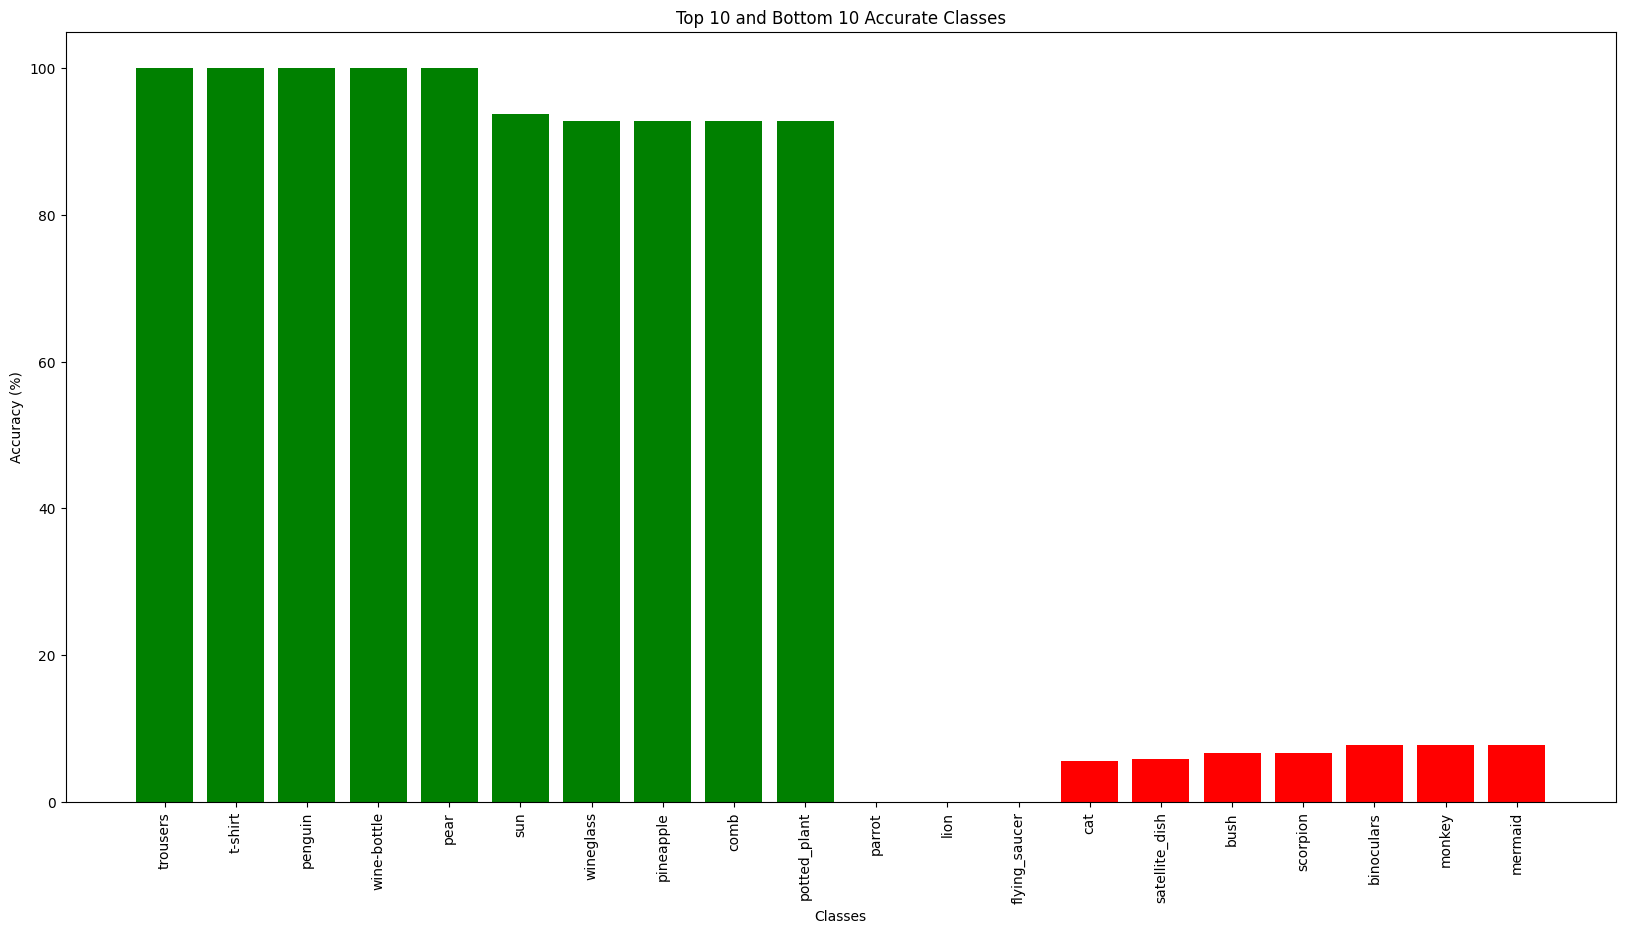

In [54]:
# Calculate class-wise accuracy
class_wise_accuracy = np.diag(mc_simple) / np.sum(mc_simple, axis=1) * 100

# Sort the accuracies and get the indices
sorted_indices = np.argsort(class_wise_accuracy)

# Get the top 10 and bottom 10 indices
top_10_indices = sorted_indices[-10:][::-1]  # Reverse to get the highest first
bottom_10_indices = sorted_indices[:10]

# Get the class names and accuracies for top 10 and bottom 10
top_10_classes = [classes[i] for i in top_10_indices]
top_10_accuracies = class_wise_accuracy[top_10_indices]

bottom_10_classes = [classes[i] for i in bottom_10_indices]
bottom_10_accuracies = class_wise_accuracy[bottom_10_indices]

# Combine top 10 and bottom 10 for plotting
all_classes = top_10_classes + bottom_10_classes
all_accuracies = np.concatenate([top_10_accuracies, bottom_10_accuracies])

# Plotting
plt.figure(figsize=(20, 10))

# Use different colors for top 10 and bottom 10
colors = ["green"] * 10 + ["red"] * 10

plt.bar(all_classes, all_accuracies, color=colors)
plt.xticks(rotation=90)
plt.xlabel("Classes")
plt.ylabel("Accuracy (%)")
plt.title("Top 10 and Bottom 10 Accurate Classes")
plt.show()

#### <a id='toc8_2_3_2_'></a>[ResNet](#toc0_)


##### <a id='toc8_2_3_2_1_'></a>[Class wise accuracy](#toc0_)


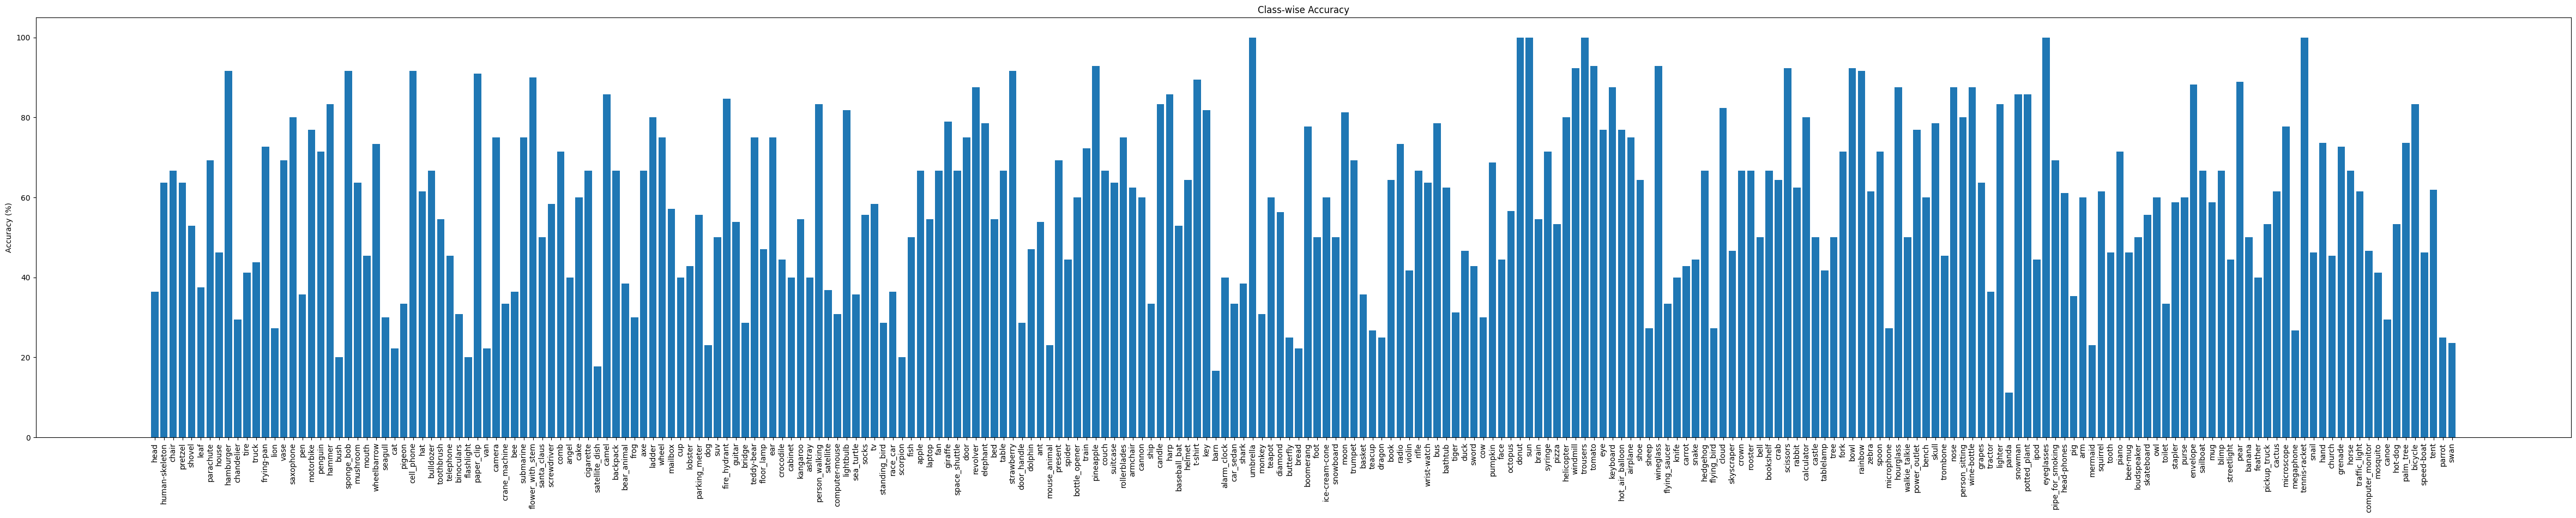

In [55]:
# Calculate class-wise accuracy
class_wise_accuracy = np.diag(mc_resnet) / np.sum(mc_resnet, axis=1) * 100

# Plotting
plt.figure(figsize=(60, 10))
plt.bar(range(NUM_CLASSES), class_wise_accuracy)
plt.xticks(range(NUM_CLASSES), labels=classes.values(), rotation=90)
plt.ylabel("Accuracy (%)")
plt.title("Class-wise Accuracy")
plt.show()

##### <a id='toc8_2_3_2_2_'></a>[Top 10 most and least accurate classes](#toc0_)


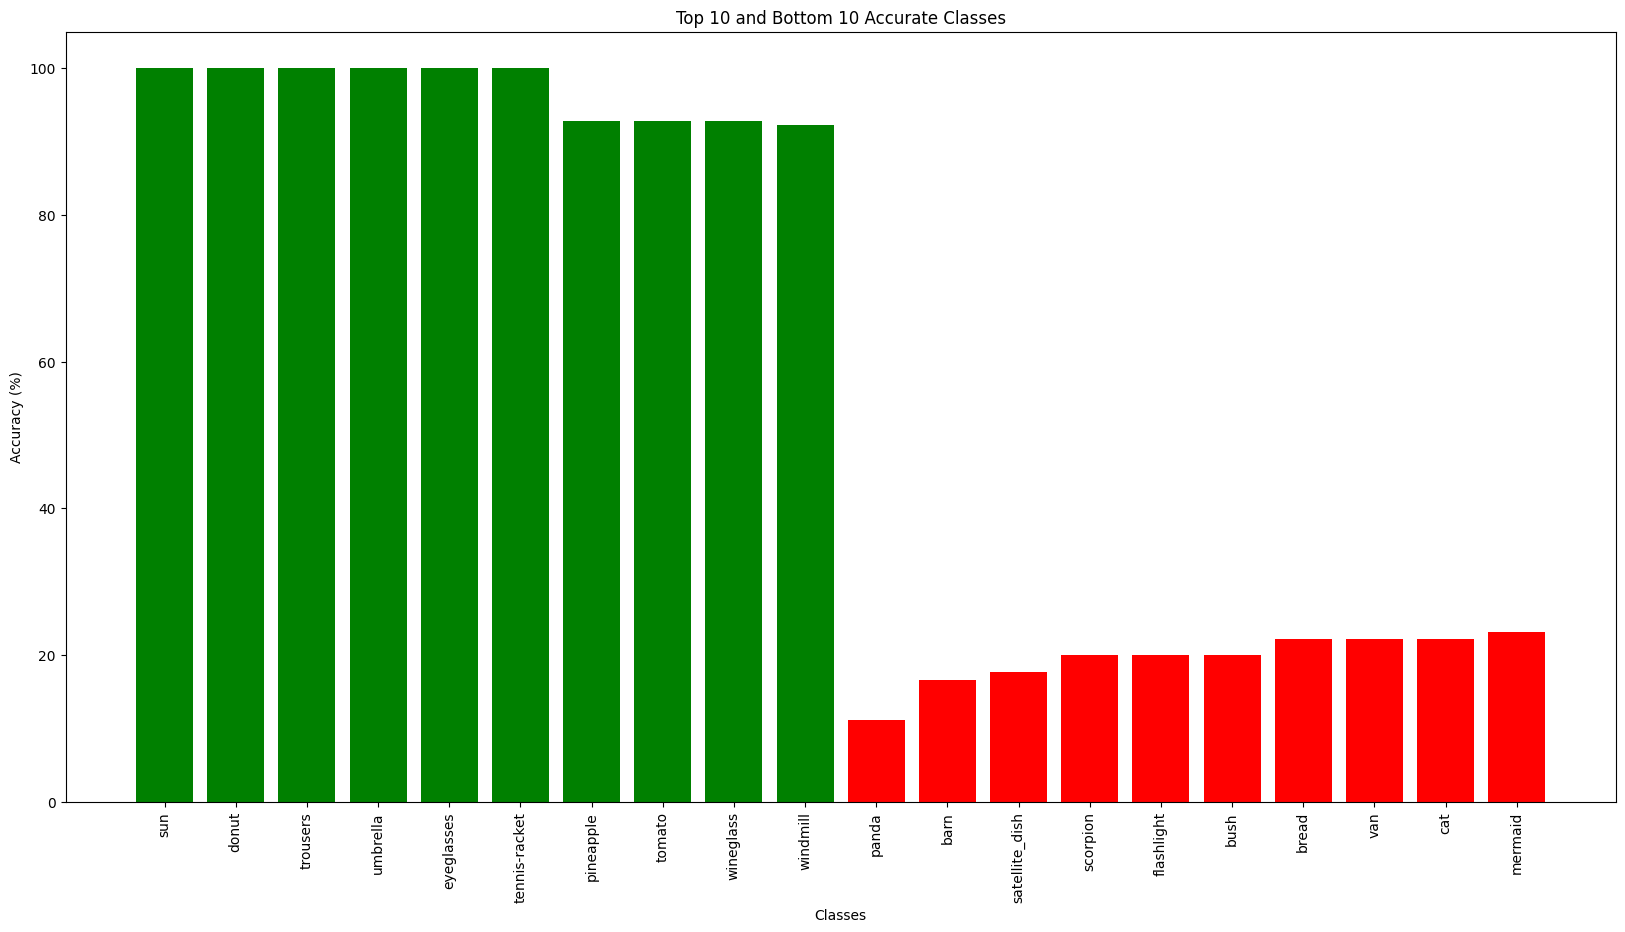

In [56]:
# Calculate class-wise accuracy
class_wise_accuracy = np.diag(mc_resnet) / np.sum(mc_resnet, axis=1) * 100

# Sort the accuracies and get the indices
sorted_indices = np.argsort(class_wise_accuracy)

# Get the top 10 and bottom 10 indices
top_10_indices = sorted_indices[-10:][::-1]  # Reverse to get the highest first
bottom_10_indices = sorted_indices[:10]

# Get the class names and accuracies for top 10 and bottom 10
top_10_classes = [classes[i] for i in top_10_indices]
top_10_accuracies = class_wise_accuracy[top_10_indices]

bottom_10_classes = [classes[i] for i in bottom_10_indices]
bottom_10_accuracies = class_wise_accuracy[bottom_10_indices]

# Combine top 10 and bottom 10 for plotting
all_classes = top_10_classes + bottom_10_classes
all_accuracies = np.concatenate([top_10_accuracies, bottom_10_accuracies])

# Plotting
plt.figure(figsize=(20, 10))

# Use different colors for top 10 and bottom 10
colors = ["green"] * 10 + ["red"] * 10

plt.bar(all_classes, all_accuracies, color=colors)
plt.xticks(rotation=90)
plt.xlabel("Classes")
plt.ylabel("Accuracy (%)")
plt.title("Top 10 and Bottom 10 Accurate Classes")
plt.show()

# <a id='toc9_'></a>[Predictions](#toc0_)


## <a id='toc9_1_'></a>[Simple](#toc0_)


Found 4000 validated image filenames belonging to 250 classes.


2023-08-30 18:18:21.156404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4000/4000 [==============================] - 16s 4ms/step


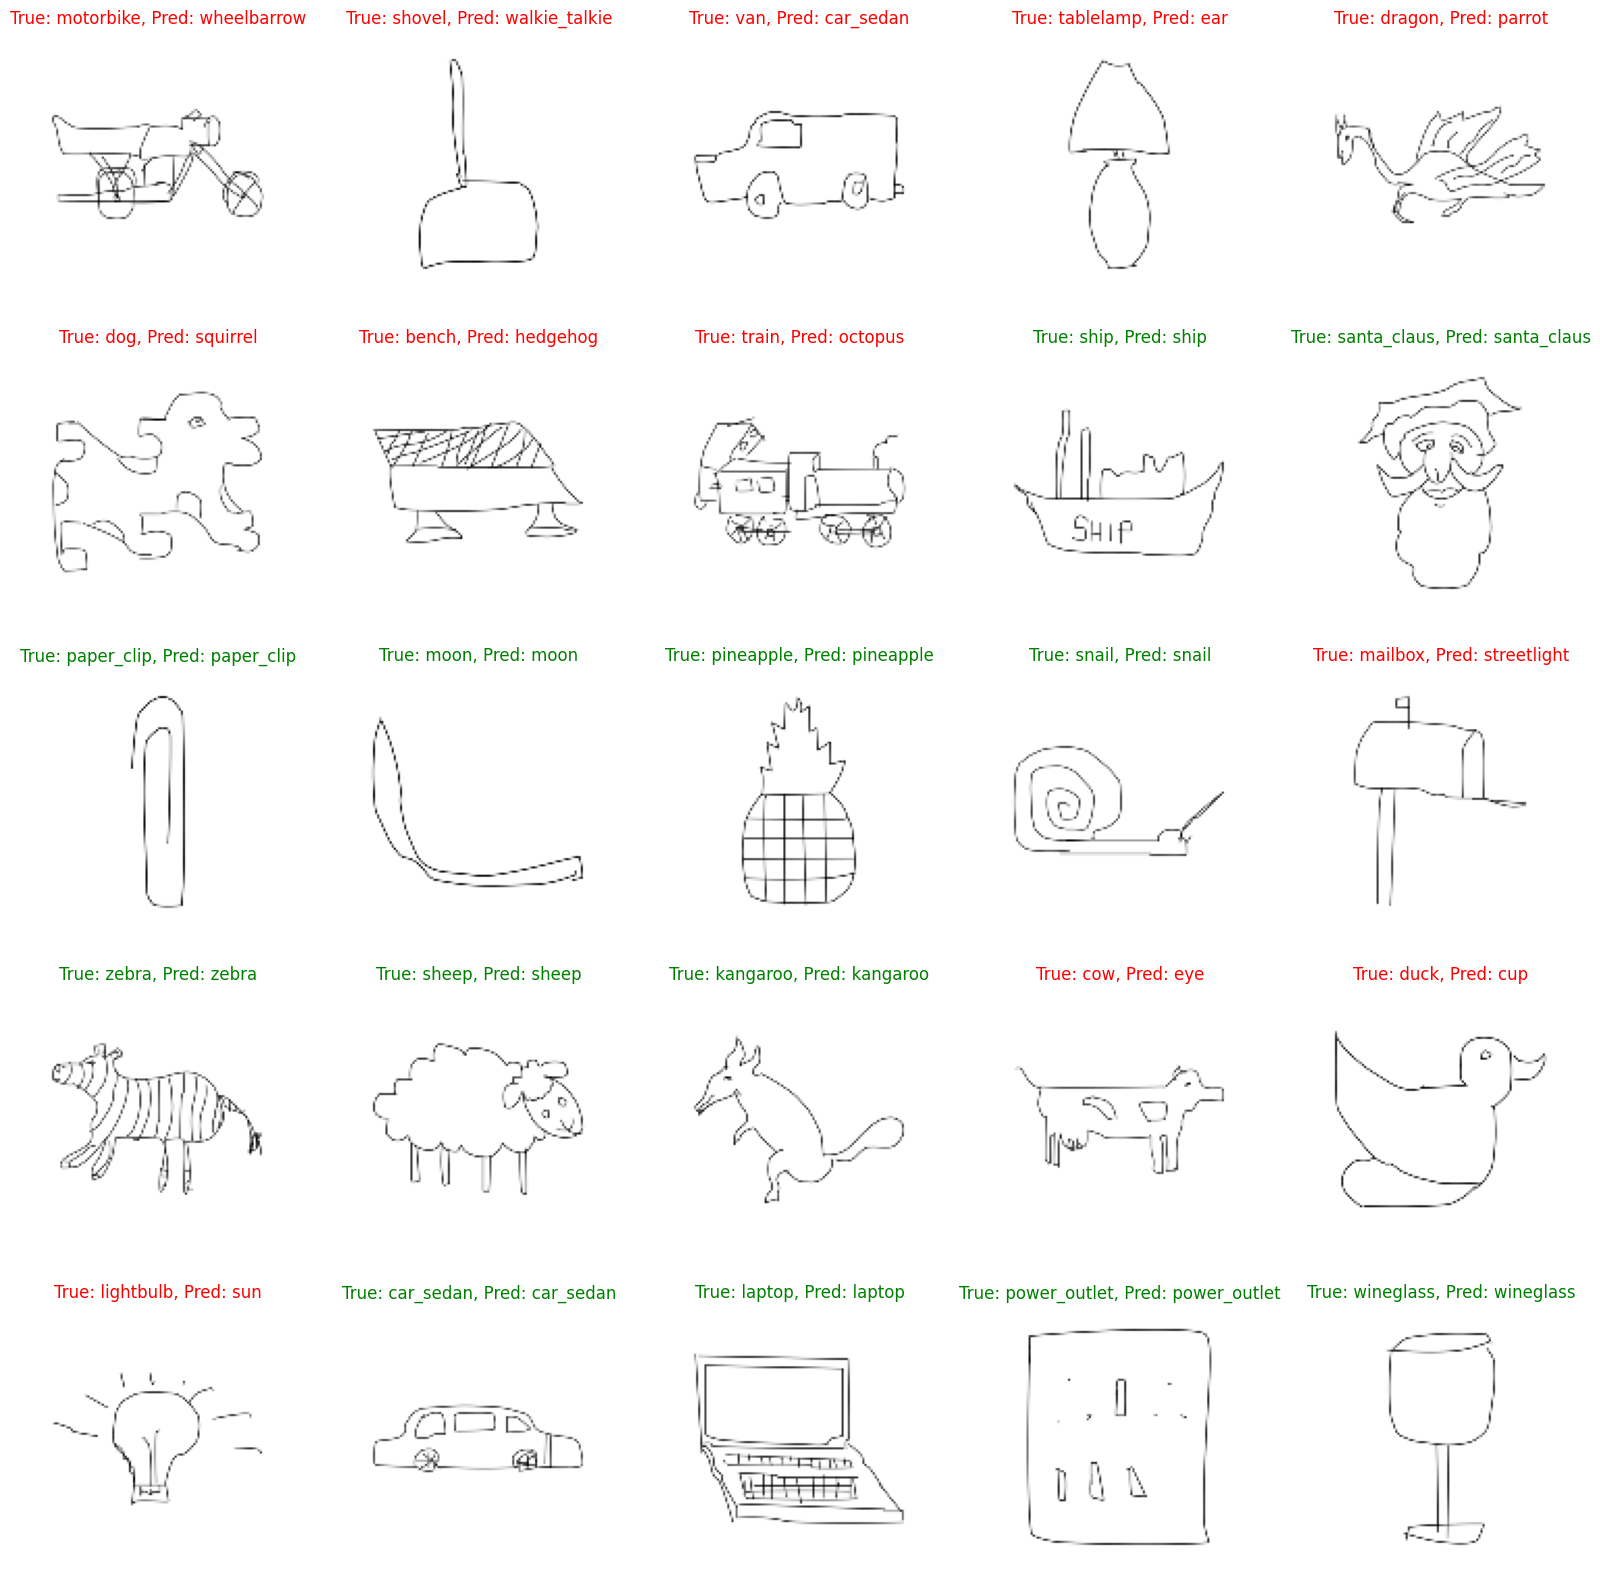

In [57]:
test_generator = train_datagen.flow_from_dataframe(
    df_test,
    x_col="images",
    y_col="labels",
    target_size=IMAGE_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    classes=list(classes.values()),  # explicitly specify the order of classes
)

# Make predictions on the test set
predictions = model_simple.predict(test_generator, steps=len(test_generator), verbose=1)

# Get the true labels from the generator
true_labels = test_generator.classes

# Convert the predictions to class indices
predicted_class_indices = np.argmax(predictions, axis=1)

# Initialize figure for displaying images
fig, axes = plt.subplots(5, 5, figsize=(20, 20))

# Loop to display the first 5 images, true labels, and predicted labels
for i in range(5):
    for j in range(5):
        test_generator.reset()
        index = i * 5 + j
        # Get the image and true label
        img, true_label = test_generator[index]
        img = np.squeeze(img)
        true_label = np.argmax(true_label)

        # Get the corresponding predicted label
        pred_label = predicted_class_indices[index]

        # Display the image, true label, and predicted label
        axes[i][j].imshow(img, cmap="gray")
        if classes[true_label] == classes[pred_label]:
            title_color = "green"
        else:
            title_color = "red"
        axes[i][j].set_title(
            f"True: {classes[true_label]}, Pred: {classes[pred_label]}",
            color=title_color,
        )
        axes[i][j].axis("off")

plt.show()

## <a id='toc9_2_'></a>[ResNet](#toc0_)


Found 4000 validated image filenames belonging to 250 classes.


2023-08-30 18:18:39.022863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4000/4000 [==============================] - 35s 8ms/step


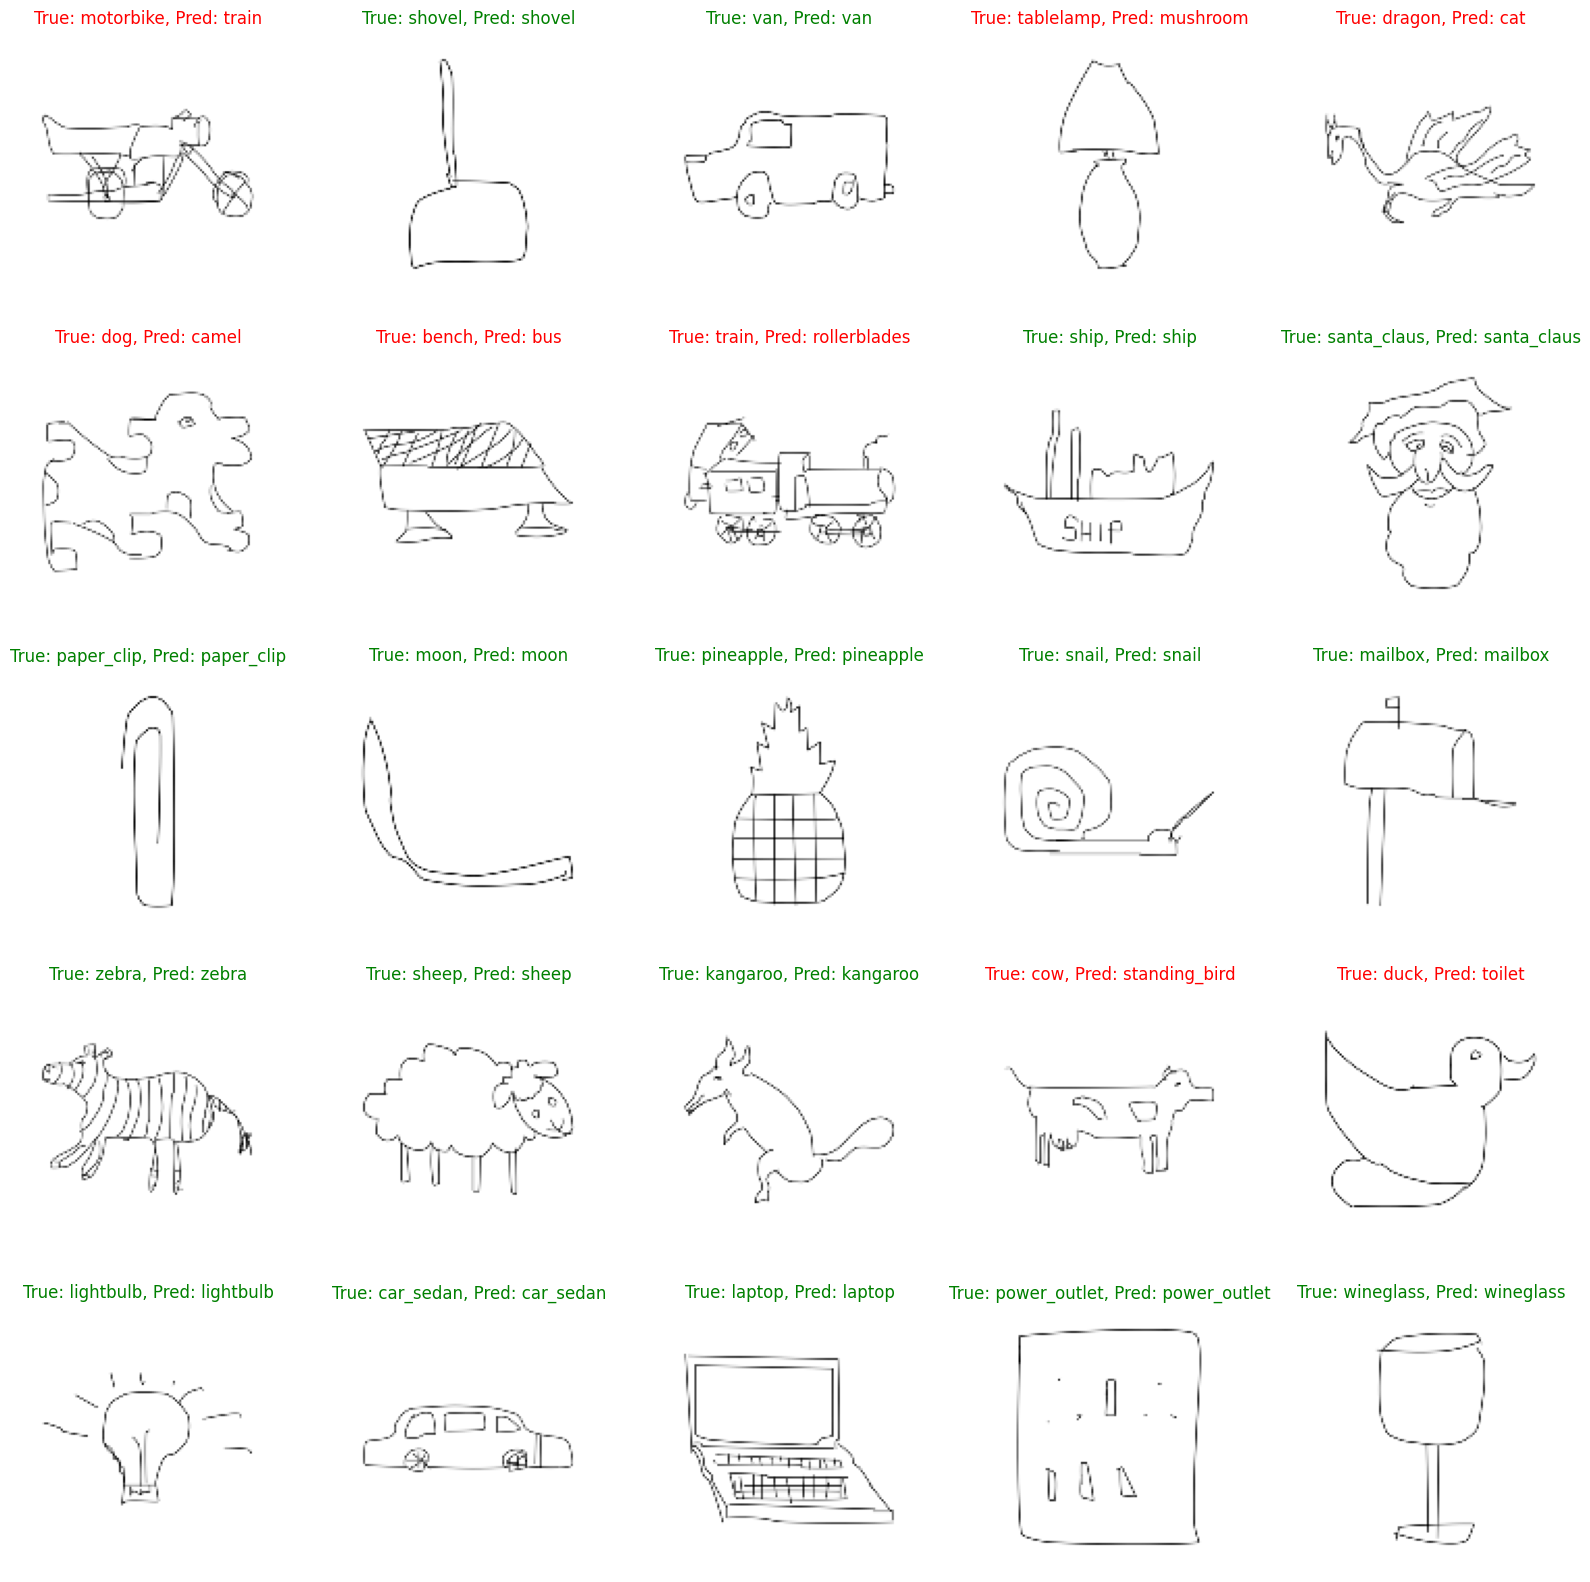

In [58]:
test_generator = train_datagen.flow_from_dataframe(
    df_test,
    x_col="images",
    y_col="labels",
    target_size=IMAGE_SIZE,
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=1,
    shuffle=False,
    classes=list(classes.values()),  # explicitly specify the order of classes
)

# Make predictions on the test set
predictions = model_resnet.predict(test_generator, steps=len(test_generator), verbose=1)

# Get the true labels from the generator
# true_labels = test_generator.classes

# TEST
true_labels = []

for i in range(len(test_generator)):
    _, label = test_generator[i]
    true_labels.append(np.argmax(label))
# TEST

# Convert the predictions to class indices
predicted_class_indices = np.argmax(predictions, axis=1)

# Initialize figure for displaying images
fig, axes = plt.subplots(5, 5, figsize=(20, 20))

# Loop to display the first 5 images, true labels, and predicted labels
for i in range(5):
    for j in range(5):
        test_generator.reset()
        index = i * 5 + j
        # Get the image and true label
        img, true_label = test_generator[index]
        img = np.squeeze(img)
        true_label = np.argmax(true_label)

        # Get the corresponding predicted label
        pred_label = predicted_class_indices[index]

        # Display the image, true label, and predicted label
        axes[i][j].imshow(img, cmap="gray")
        if classes[true_label] == classes[pred_label]:
            title_color = "green"
        else:
            title_color = "red"
        axes[i][j].set_title(
            f"True: {classes[true_label]}, Pred: {classes[pred_label]}",
            color=title_color,
        )
        axes[i][j].axis("off")

plt.show()